In [1]:
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm

# A20 discharge based on RADR and MERIT-Hydro

Aims:

 * Identify MERIT-Hydro basins flowing into the Arctic Ocean
 * Merge all sub-basins to create a single watershed polygon for each MERIT-Hydro river system
 * Link MERIT-Hydro catchment IDs to the RADR dataset to generate a shapefile of RADR catchments, and calculate catchment area
 * Estimate **mean** monthly discharge (m3/s) for each RADR catchment draining to the coast and save as netcdf
 * Reproject to Polar Stereographic so that Andre can link outflow locations to A20 grid cells
 
 Points for follow-up:
 - We found quite a few MERIT-Hydro catchments in Siberia that didn't drain anywhere. This didn't match with e.g. the ArcticGRO catchment boundaries, so we decided to merge these catchments into the larger catchments they lay within. However, subsequent reading suggests that there are some large endorrheic catchments in Siberia, and that in fact perhaps we should just trust MERIT-Hydro. i.e. re-run this notebook without all the special treatment in Siberia?

## 1. MERIT-Hydro spatial data

Data can be downloaded from [here](http://hydrology.princeton.edu/data/mpan/MERIT_Basins/).

### 1.1. Aggregate spatial data

The code below processes the data for each MERIT-Hydro region and merges it into a single dataset (one file for rivers and one for catchments). For each river segment, the code follows the river network downstream to find the ID of the river outlet segment. This ID is used to merge all subcatchments for each river system into a single polygon (interior holes are also removed). 

A point shapefile of catchment outlets is also created from the downstream-most point in each river system. Looking at the data in ArcGIS, it seems that all river segments are digitised *from the lowest point upstream* i.e. the **first** point in the outflow river segment is the outflow.

All datasets are reprojected to a Polar Stereographic projection with the same parameters as the A20 grid.

#### Update (27.06.2022)

As noted in the original version of this notebook, the MERIT-Hydro data for northern Asia (region 3) includes some disconnected river segments within the Ob, Yenisey and Lena watersheds (i.e. `NextDownID=0`, even though the segment is in the middle of the continent). After comparison with the ArcticGRO geospatial data (`shared/pan_arctic_data/ArcticGRO_spatial_data/ArcticGRO_large_watersheds.shp`), it is obvious that these disconnected segments are errors in MERIT-Hydro, rather than genuine sink holes. We therefore need to modify the MERIT-Hydro data to link these river segments to the correct parent catchment.

In the code below, the processing for region 3 includes the following additional steps to clean the MERIT-Hydro data:

 1. Use ArcticGRO to identify all MERIT-Hydro river segments within the Ob, Yenisey and Lena catchments (as defined by ArcticGRO)
 
 2. Within each catchment, any river segment with `NextDowID=0` has its `NextDownID` adjusted to equal that of the parent catchment (defined in `out_com_id_dict`, below). This ensure that these segments (which would otherwise be disconnected) are assigned to the correct parent basin during subsequent processing

In [2]:
hydro_regions = [2, 3, 8, 9]
agro_shp_path = (
    r"~/shared/pan_arctic_data/ArcticGRO_spatial_data/ArcticGRO_large_watersheds.shp"
)
a20_proj4_str = "+proj=stere +R=6371000.0 +lat_0=90 +lat_ts=60.0 +x_0=4180000.0 +y_0=2570000.0 +lon_0=58.0"

# Output file paths
hydro_regions_str = "".join([str(i) for i in hydro_regions])
out_cat_shp = f"~/shared/pan_arctic_data/merit_hydro_basins/merit_hydro_cats_{hydro_regions_str}_merged.shp"
out_riv_shp = f"~/shared/pan_arctic_data/merit_hydro_basins/merit_hydro_rivs_{hydro_regions_str}_merged.shp"
out_pt_shp = f"~/shared/pan_arctic_data/merit_hydro_basins/merit_hydro_outlets_{hydro_regions_str}_merged.shp"

# COMIDs for Ob, Yenisey and Lena. Used to fix MERIT-Hydro in region 3 (see above)
out_com_id_dict = {
    "Ob": 31006084,
    "Yenisey": 32000794,
    "Lena": 34000655,
}

In [3]:
# Loop over regions
cat_gdf_list = []
riv_gdf_list = []
agro_gdf = gpd.read_file(agro_shp_path)
for reg in tqdm(hydro_regions, desc="Looping over regions"):
    cat_shp_path = f"~/shared/pan_arctic_data/merit_hydro_basins/cat_pfaf_{reg}_MERIT_Hydro_v07_Basins_v01.shp"
    riv_shp_path = f"~/shared/pan_arctic_data/merit_hydro_basins/riv_pfaf_{reg}_MERIT_Hydro_v07_Basins_v01.shp"
    cat_gdf = gpd.read_file(cat_shp_path)
    cat_gdf.set_index("COMID", inplace=True)
    riv_gdf = gpd.read_file(riv_shp_path)
    riv_gdf.set_index("COMID", inplace=True)

    if reg == 3:
        # Fix disconnected catchments in N. Asia (see above)
        rivs_in_agro_gdf = riv_gdf.to_crs(a20_proj4_str).sjoin(
            agro_gdf.to_crs(a20_proj4_str), how="inner", predicate="within"
        )
        for cat_name, com_id in out_com_id_dict.items():
            com_ids = rivs_in_agro_gdf.query(
                "(NextDownID == 0) and (name == @cat_name)"
            ).index
            riv_gdf.loc[com_ids, ["NextDownID"]] = com_id

    # Get list of all river outlets for checking
    riv_outlet_ids = riv_gdf.query("NextDownID == 0").index.unique()

    # For each river segment, follow network downstream to find outflow ID
    outlet_comids = []
    for comid, row in tqdm(
        riv_gdf.iterrows(),
        total=riv_gdf.shape[0],
        desc=f"Finding downstream outlets in region {reg}",
    ):
        next_down_id = row["NextDownID"]
        while next_down_id != 0:
            comid = next_down_id
            next_down_id = riv_gdf.loc[comid, "NextDownID"]
        assert comid in riv_outlet_ids
        outlet_comids.append(comid)
    riv_gdf["OutCOMID"] = outlet_comids

    print(f"Dissolving catchments in region {reg}")
    cat_gdf = cat_gdf.join(riv_gdf["OutCOMID"])
    cat_gdf = cat_gdf.dissolve(by="OutCOMID")
    del cat_gdf["unitarea"]

    cat_gdf_list.append(cat_gdf)
    riv_gdf_list.append(riv_gdf)

print("Merging catchments")
cat_gdf = pd.concat(cat_gdf_list, axis="rows").reset_index()
riv_gdf = pd.concat(riv_gdf_list, axis="rows").reset_index()

print("Cleaning polygons")
cat_gdf = cat_gdf.explode(index_parts=False).reset_index()
cat_gdf.geometry = cat_gdf.geometry.apply(
    lambda p: nivapy.spatial.remove_polygon_holes(p)
)
cat_gdf = cat_gdf.dissolve(by="OutCOMID").reset_index()
cat_gdf = cat_gdf[["OutCOMID", "geometry"]]

# Explicitly set CRS, since it is not defined correctly in some of the raw files
cat_gdf.set_crs("epsg:4326", inplace=True)
riv_gdf.set_crs("epsg:4326", inplace=True)

print("Extracting outflow points")
pt_gdf = riv_gdf.query("NextDownID == 0").copy()

# 'boundary' gets the start and end points of the line segment as a Multipoint.
# Explode converts Multipoints to Points and the 'query' gets just the first point
pt_gdf["geometry"] = (
    pt_gdf["geometry"]
    .boundary.explode(index_parts=True)
    .reset_index()
    .query("level_1 == 0")[0]
    .values
)
pt_gdf["lon"] = pt_gdf.geometry.x
pt_gdf["lat"] = pt_gdf.geometry.y
pt_gdf = pt_gdf[["COMID", "lon", "lat", "geometry"]]
pt_gdf.rename({"COMID": "OutCOMID"}, axis="columns", inplace=True)

print("Reprojecting")
cat_gdf = cat_gdf.to_crs(a20_proj4_str)
riv_gdf = riv_gdf.to_crs(a20_proj4_str)
pt_gdf = pt_gdf.to_crs(a20_proj4_str)

# Save
print("Saving")
cat_gdf.to_file(out_cat_shp)
riv_gdf.to_file(out_riv_shp)
pt_gdf.to_file(out_pt_shp)

print("Done")

Looping over regions:   0%|          | 0/4 [00:00<?, ?it/s]

Finding downstream outlets in region 2:   0%|          | 0/393464 [00:00<?, ?it/s]

Dissolving catchments in region 2


Finding downstream outlets in region 3:   0%|          | 0/288613 [00:00<?, ?it/s]

Dissolving catchments in region 3


Finding downstream outlets in region 8:   0%|          | 0/128717 [00:00<?, ?it/s]

Dissolving catchments in region 8


Finding downstream outlets in region 9:   0%|          | 0/42246 [00:00<?, ?it/s]

Dissolving catchments in region 9
Merging catchments
Cleaning polygons
Extracting outflow points
Reprojecting
Saving


/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Done


In [4]:
# out_gpkg = f"~/shared/pan_arctic_data/merit_hydro_basins/merit_hydro_merged_regions_{hydro_regions_str}.gpkg"
# cat_gdf.to_file(out_gpkg, layer='catchments', driver="GPKG")
# riv_gdf.to_file(out_gpkg, layer='rivers', driver="GPKG")
# pt_gdf.to_file(out_gpkg, layer='outlets', driver="GPKG")

### 1.2. Subset MERIT-Hydro basins to match RADR

The code above processes data for whole MERIT-Hydro regions, but we are interested in the RADR dataset (which just covers the Arctic). The code below gets the MERIT-Hydro outflows that are within RADR.

In [5]:
# Get RADR IDs
radr_path = r"/home/jovyan/shared/pan_arctic_data/discharge/RADR_v1.0.0.nc"
ds = xr.open_dataset(radr_path)
radr_ids = ds["reach"].values
ds.close()

Some of the MERIT-Hydro basins in northern Asia (e.g. Kazakhstan) do not drain anywhere i.e. there are isolated river segments/systems in the middle of the continent where `NextDownID = 0`. This is either an error in MERIT-Hydro or else the these rivers must drain to sinkholes rather than the sea (which seems unlikely from a brief check of Google Maps). Either way, we do not want to include these basins as outlets, so they are filtered out in the code below based on their on lat/lon co-ordinates (I have confirmed using ArcGIS that the query used here preserves the locations of interest).

In [6]:
radr_cat_shp = f"~/shared/pan_arctic_data/merit_hydro_basins/radr_cats_merged.shp"
radr_riv_shp = f"~/shared/pan_arctic_data/merit_hydro_basins/radr_rivs_merged.shp"
radr_pt_shp = f"~/shared/pan_arctic_data/merit_hydro_basins/radr_outlets_merged.shp"

# Subset to basins within RADR
radr_cat_gdf = cat_gdf.query("OutCOMID in @radr_ids")
radr_riv_gdf = riv_gdf.query("OutCOMID in @radr_ids")
radr_pt_gdf = pt_gdf.query("OutCOMID in @radr_ids")

# Exclude "within continent" outlets in Asia
incont_cat_ids = radr_pt_gdf.query("(lat < 63.2) and (61.4 < lon < 133)")[
    "OutCOMID"
].unique()
radr_cat_gdf = radr_cat_gdf.query("OutCOMID not in @incont_cat_ids")
radr_riv_gdf = radr_riv_gdf.query("OutCOMID not in @incont_cat_ids")
radr_pt_gdf = radr_pt_gdf.query("OutCOMID not in @incont_cat_ids")

radr_cat_gdf.to_file(radr_cat_shp)
radr_riv_gdf.to_file(radr_riv_shp)
radr_pt_gdf.to_file(radr_pt_shp)

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## 2. Resample RADR to monthly and subset to main outlets only

RADR includes data for lots of sub-basins, but we only need outflows to the coastline. The code above identified catchments that (i) flow to the coast and (ii) are in RADR. The code here subsets the RADR data to match (i.e. get RADR data for just those catchments that flow to the coast).

In [7]:
radr_pt_shp = f"~/shared/pan_arctic_data/merit_hydro_basins/radr_outlets_merged.shp"
radr_pt_gdf = gpd.read_file(radr_pt_shp)
cat_ids = radr_pt_gdf["OutCOMID"].unique()

In [ ]:
%%time

radr_path = r"/home/jovyan/shared/pan_arctic_data/discharge/RADR_v1.0.0.nc"
radr_monthly_path = r"/home/jovyan/shared/pan_arctic_data/discharge/RADR_v1_monthly.nc"

ds = xr.open_dataset(radr_path)
ds = ds.sel(reach=cat_ids)
ds = ds.resample(time="M").mean()
ds.to_netcdf(radr_monthly_path)
ds

CPU times: user 6min 2s, sys: 11min 20s, total: 17min 23s
Wall time: 25min 20s


<xarray.Dataset>
Dimensions:    (time: 420, reach: 10658)
Coordinates:
  * time       (time) datetime64[ns] 1984-01-31 1984-02-29 ... 2018-12-31
  * reach      (reach) float64 2.5e+07 2.5e+07 2.5e+07 ... 8.601e+07 8.601e+07
Data variables:
    discharge  (time, reach) float32 0.1273 0.2571 ... 0.001258 0.001226

In [9]:
ds.close()

## 3. Plot outflows on A20 grid

In [10]:
a20_path = "~/shared/pan_arctic_data/A20niva_grd_v1.nc"
a20_ds = xr.open_dataset(a20_path)
a20_ds

<xarray.Dataset>
Dimensions:       (xi_rho: 322, eta_rho: 242, xi_u: 321, eta_u: 242, xi_v: 322,
                   eta_v: 241, bath: 1, eta_psi: 241, xi_psi: 321)
Coordinates:
  * xi_rho        (xi_rho) float32 -1.2e+04 8e+03 ... 6.388e+06 6.408e+06
  * eta_rho       (eta_rho) float32 -1.2e+04 8e+03 ... 4.788e+06 4.808e+06
  * xi_u          (xi_u) float32 -2e+03 1.8e+04 3.8e+04 ... 6.378e+06 6.398e+06
  * eta_u         (eta_u) float32 -1.2e+04 8e+03 2.8e+04 ... 4.788e+06 4.808e+06
  * xi_v          (xi_v) float32 -1.2e+04 8e+03 2.8e+04 ... 6.388e+06 6.408e+06
  * eta_v         (eta_v) float32 -2e+03 1.8e+04 3.8e+04 ... 4.778e+06 4.798e+06
    lon_rho       (eta_rho, xi_rho) float32 ...
    lat_rho       (eta_rho, xi_rho) float32 ...
    lon_u         (eta_u, xi_u) float32 ...
    lat_u         (eta_u, xi_u) float32 ...
    lon_v         (eta_v, xi_v) float32 ...
    lat_v         (eta_v, xi_v) float32 ...
Dimensions without coordinates: bath, eta_psi, xi_psi
Data variables: (12/16)
    grid_mapping  int32 ...
    angle         (eta_rho, xi_rho) float32 ...
    f             (eta_rho, xi_rho) float32 ...
    spherical     |S1 ...
    pm            (eta_rho, xi_rho) float32 ...
    pn            (eta_rho, xi_rho) float32 ...
    ...            ...
    mask_rho      (eta_rho, xi_rho) float32 ...
    mask_u        (eta_u, xi_u) float32 ...
    mask_v        (eta_v, xi_v) float32 ...
    xl            float32 ...
    el            float32 ...
    mask_psi      (eta_psi, xi_psi) float64 ...
Attributes:
    history:                   Mon Sep 12 13:18:03 2016: ncks -v h newhraw2.n...
    NCO:                       4.4.2
    nco_openmp_thread_number:  1

<AxesSubplot:xlabel='X coordinate of RHO-points\n[meter]', ylabel='Y coordinate of RHO-points\n[meter]'>

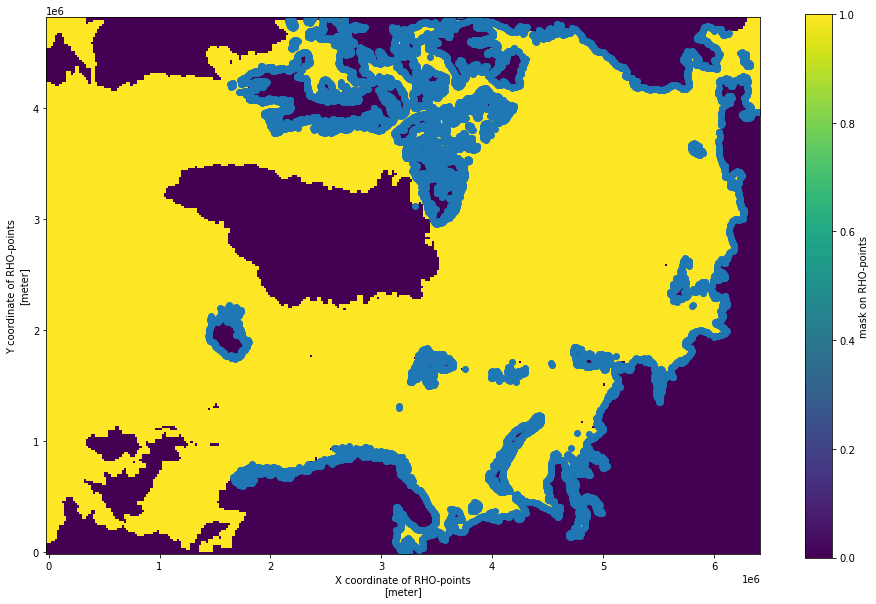

In [11]:
radr_pt_shp = f"~/shared/pan_arctic_data/merit_hydro_basins/radr_outlets_merged.shp"
radr_pt_gdf = gpd.read_file(radr_pt_shp)

fig, ax = plt.subplots(figsize=(16, 10))
a20_ds["mask_rho"].plot(ax=ax)
radr_pt_gdf.plot(ax=ax)

## 4. Add catchment area

Requested by Leah on 27.06.2022. Add area as an additional field in the catchments attribute table.

**Note:** A cylindrical equal area projection (e.g. `.to_crs({"proj": "cea"})` in Geopandas or `LambertCylindrical(central_longitude=0.0)` in Cartopy) is often a good choice for area calculations, *except* in cases where polygons may cross the line 180 degrees round from the `central_longitude`. If this happens, polygons will be split at the "dateline", giving misleading area estimates. One option is to define the central longitude such that the dateline does not intersect any polygons. A safer alternative in most cases is to define a custom Lambert Azimuthal Equal Area projection centred on the area of interest. This is the approach taken below.

/opt/conda/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:845: UserWarning: Approximating coordinate system <Geographic 2D CRS: +proj=lonlat +datum=WGS84 +ellps=WGS84 +no_defs +t ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '


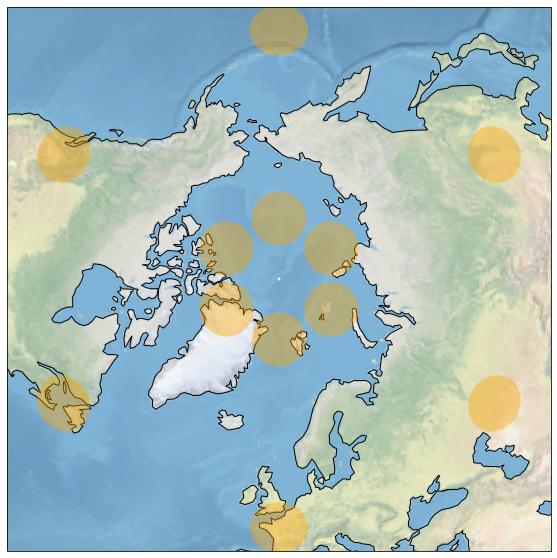

In [12]:
# Identify a suitable equal area projection with no "singularities"
# or discontinuities around the poles
crs = ccrs.LambertAzimuthalEqualArea(
    central_longitude=0.0,
    central_latitude=90.0,
    false_easting=0.0,
    false_northing=0.0,
)

# Plot Tissot indicatrices
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_extent((-5000000, 5000000, -5000000, 5000000), crs=crs)
ax.stock_img()
ax.coastlines()
ax.tissot(facecolor="orange", alpha=0.4)

In [13]:
# Add catchment areas and save
radr_cat_shp = f"~/shared/pan_arctic_data/merit_hydro_basins/radr_cats_merged.shp"
radr_cat_gdf = gpd.read_file(radr_cat_shp)
radr_cat_gdf["area_km2"] = radr_cat_gdf.to_crs(crs.proj4_init)["geometry"].area / 1e6
radr_cat_gdf.to_file(radr_cat_shp)

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
